In [1]:
import sys
sys.path.append('/kaggle/input/kerasapplications/')
sys.path.append('/kaggle/input/efficientnet-keras-source-code/')
import keras_applications
import efficientnet.tfkeras as efficientnet

In [2]:
import os
import cv2
import time 
import shutil
import warnings
import random as rn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from keras import backend as K
from keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers, applications
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback, LearningRateScheduler
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tqdm import tqdm_notebook

%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

t_start = time.time()

In [3]:
# Set seed for reproducability
seed = 1234
rn.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

In [4]:
KAGGLE_DIR = '../input/aptos2019-blindness-detection/'
TRAIN_DF_PATH = KAGGLE_DIR + "train.csv"
TEST_DF_PATH = KAGGLE_DIR + "test.csv"
TRAIN_IMG_PATH = KAGGLE_DIR + "train_images/"
TEST_IMG_PATH = KAGGLE_DIR + "test_images/"

In [5]:
print("Im5ge IDs and Labels (TRAIN)")
train_df = pd.read_csv(TRAIN_DF_PATH)
train_df["id_code"] = train_df["id_code"].apply(lambda x : x + ".png")
train_df["diagnosis"] = train_df["diagnosis"].astype('str')
print(f"Training images: {train_df.shape[0]}")
display(train_df.head())
      
print("Image IDs (TEST)")
test_df = pd.read_csv(TEST_DF_PATH)
test_df["id_code"] = test_df["id_code"].apply(lambda x : x + ".png")
print(f"Testing Images: {test_df.shape[0]}")
display(test_df.head())

Im5ge IDs and Labels (TRAIN)
Training images: 3662


,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0


Image IDs (TEST)
Testing Images: 1928


,id_code
0,0005cfc8afb6.png
1,003f0afdcd15.png
2,006efc72b638.png
3,00836aaacf06.png
4,009245722fa4.png


In [6]:
N_CLASSES = train_df["diagnosis"].nunique()
BATCH_SIZE = 4
EPOCHS = 30
LEARNING_RATE = 3e-4
WIDTH = 456
HEIGHT = 456
CHANNELS = 3
ES_PATIENCE = 12
RLROP_PATIENCE = 4
DECAY_DROP = 0.5

In [7]:
def kappa(y_true, y_pred, n_classes=5):
    y_trues = K.cast(K.argmax(y_true), K.floatx())
    y_preds = K.cast(K.argmax(y_pred), K.floatx())
    n_samples = K.cast(K.shape(y_true)[0], K.floatx())
    distance = K.sum(K.abs(y_trues - y_preds))
    max_distance = n_classes - 1
    
    kappa_score = 1 - ((distance**2)/(n_samples * (max_distance**2)))
    
    return kappa_score

In [8]:
def crop_image_from_gray(img, tol=7):
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1), mask.any(0))]
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1), mask.any(0))].shape[0]
        if (check_shape == 0):
            return img
        else:
            img1 = img[:,:,0][np.ix_(mask.any(1), mask.any(0))]
            img2 = img[:,:,1][np.ix_(mask.any(1), mask.any(0))]
            img3 = img[:,:,2][np.ix_(mask.any(1), mask.any(0))]
            img = np.stack([img1, img2, img3], axis=-1)
            
        return img

def preprocess_image(image, sigmaX=10):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (WIDTH, HEIGHT))
    image = cv2.addWeighted(image, 4, cv2.GaussianBlur(image, (0,0), sigmaX), -4, 128)
    return image

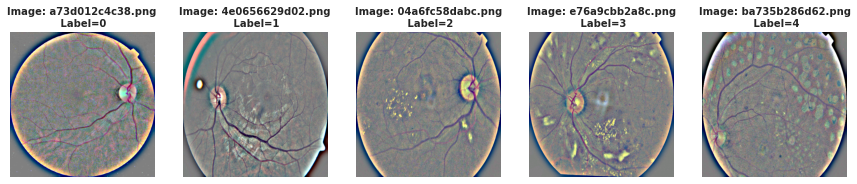

In [9]:
# Example of preprocessed images from every label

fig, ax = plt.subplots(1, 5, figsize=(15,6))
for i in range(5):
    sample = train_df[train_df['diagnosis'] == str(i)].sample(1)
    image_name = sample['id_code'].item()
    X = preprocess_image(cv2.imread(f"{TRAIN_IMG_PATH}{image_name}"))
    ax[i].set_title(f"Image: {image_name}\n Label={sample['diagnosis'].item()}",
                   weight='bold', fontsize=10)
    ax[i].axis('off')
    ax[i].imshow(X)

In [10]:
datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=360,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   preprocessing_function=preprocess_image,
                                   validation_split=0.15)

train_generator = datagen.flow_from_dataframe(train_df,
                                                    x_col='id_code',
                                                    y_col='diagnosis',
                                                    directory=TRAIN_IMG_PATH,
                                                    target_size=(WIDTH, HEIGHT),
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                    subset='training',
                                                    seed=seed)

val_generator = datagen.flow_from_dataframe(train_df,
                                                  x_col='id_code',
                                                  y_col='diagnosis',
                                                  directory=TRAIN_IMG_PATH,
                                                  target_size=(WIDTH, HEIGHT),
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='categorical',
                                                  subset='validation',
                                                  seed=seed)

# # TTA
# test_generator = datagen.flow_from_dataframe(test_df,
#                                              x_col='id_code',
#                                              directory=TEST_IMG_PATH,
#                                              target_size=(WIDTH, HEIGHT),
#                                              batch_size=1,
#                                              class_mode=None, 
#                                              shuffle=False,
#                                              seed=seed)

Found 3113 validated image filenames belonging to 5 classes.
Found 549 validated image filenames belonging to 5 classes.


In [11]:
effnet = efficientnet.EfficientNetB5(weights=None,
                        include_top=False,
                        input_shape=(HEIGHT, WIDTH, CHANNELS))
effnet.load_weights('/kaggle/input/efficientnet-keras-weights-b0b5/efficientnet-b5_imagenet_1000_notop.h5')

2023-01-13 16:01:38.945661: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-13 16:01:39.038317: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-13 16:01:39.039219: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-13 16:01:39.041382: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [12]:
# # Replace all Batch Normalization layers by Group Normalization layers
# for i, layer in enumerate(effnet.layers):
#     if "batch_normalization" in layer.name:
#         effnet.layers[i] = GroupNormalization(groups=32, axis=-1, epsilon=0.00001)

### regression

In [13]:
def build_model(n_out):
            
    model = Sequential()
    model.add(effnet)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(n_out, activation='softmax'))
    return model 

In [14]:
model = build_model(n_out=N_CLASSES)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b5 (Functional) (None, 15, 15, 2048)      28513520  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 10245     
Total params: 28,523,765
Trainable params: 28,351,029
Non-trainable params: 172,736
_________________________________________________________________


In [15]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = val_generator.n//val_generator.batch_size

In [16]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

# class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(train_df['diagnosis'].astype('int').values),
#                                                 y=train_df['diagnosis'].astype('int').values)
# class_weights = {i:class_weights[i] for i in range(5)}

callback_list = [es, rlrop]
metric_list = ["accuracy", kappa]

optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=metric_list)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b5 (Functional) (None, 15, 15, 2048)      28513520  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 10245     
Total params: 28,523,765
Trainable params: 28,351,029
Non-trainable params: 172,736
_________________________________________________________________


In [17]:
history_finetunning = model.fit_generator(generator=train_generator, 
                                          steps_per_epoch=STEP_SIZE_TRAIN, 
                                          epochs=EPOCHS, 
                                          validation_data=val_generator,
                                          validation_steps=STEP_SIZE_VALID,
                                          callbacks=callback_list,
#                                           class_weight=class_weights,
                                          verbose=1).history

2023-01-13 16:01:48.994316: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2023-01-13 16:02:10.441352: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


778/778 [==============================] - 825s 1s/step - loss: 0.7673 - accuracy: 0.7160 - kappa: 0.9049 - val_loss: 0.5832 - val_accuracy: 0.7938 - val_kappa: 0.9621
Epoch 2/30
778/778 [==============================] - 733s 942ms/step - loss: 0.5709 - accuracy: 0.7832 - kappa: 0.9543 - val_loss: 0.5141 - val_accuracy: 0.8139 - val_kappa: 0.9528
Epoch 3/30
778/778 [==============================] - 755s 971ms/step - loss: 0.5166 - accuracy: 0.8041 - kappa: 0.9633 - val_loss: 0.5479 - val_accuracy: 0.8139 - val_kappa: 0.9651
Epoch 4/30
778/778 [==============================] - 733s 941ms/step - loss: 0.4816 - accuracy: 0.8202 - kappa: 0.9666 - val_loss: 0.4881 - val_accuracy: 0.8175 - val_kappa: 0.9706
Epoch 5/30
778/778 [==============================] - 727s 934ms/step - loss: 0.4643 - accuracy: 0.8260 - kappa: 0.9669 - val_loss: 0.7975 - val_accuracy: 0.7920 - val_kappa: 0.9571
Epoch 6/30
778/778 [==============================] - 724s 930ms/step - loss: 0.4365 - accuracy: 0.8353 

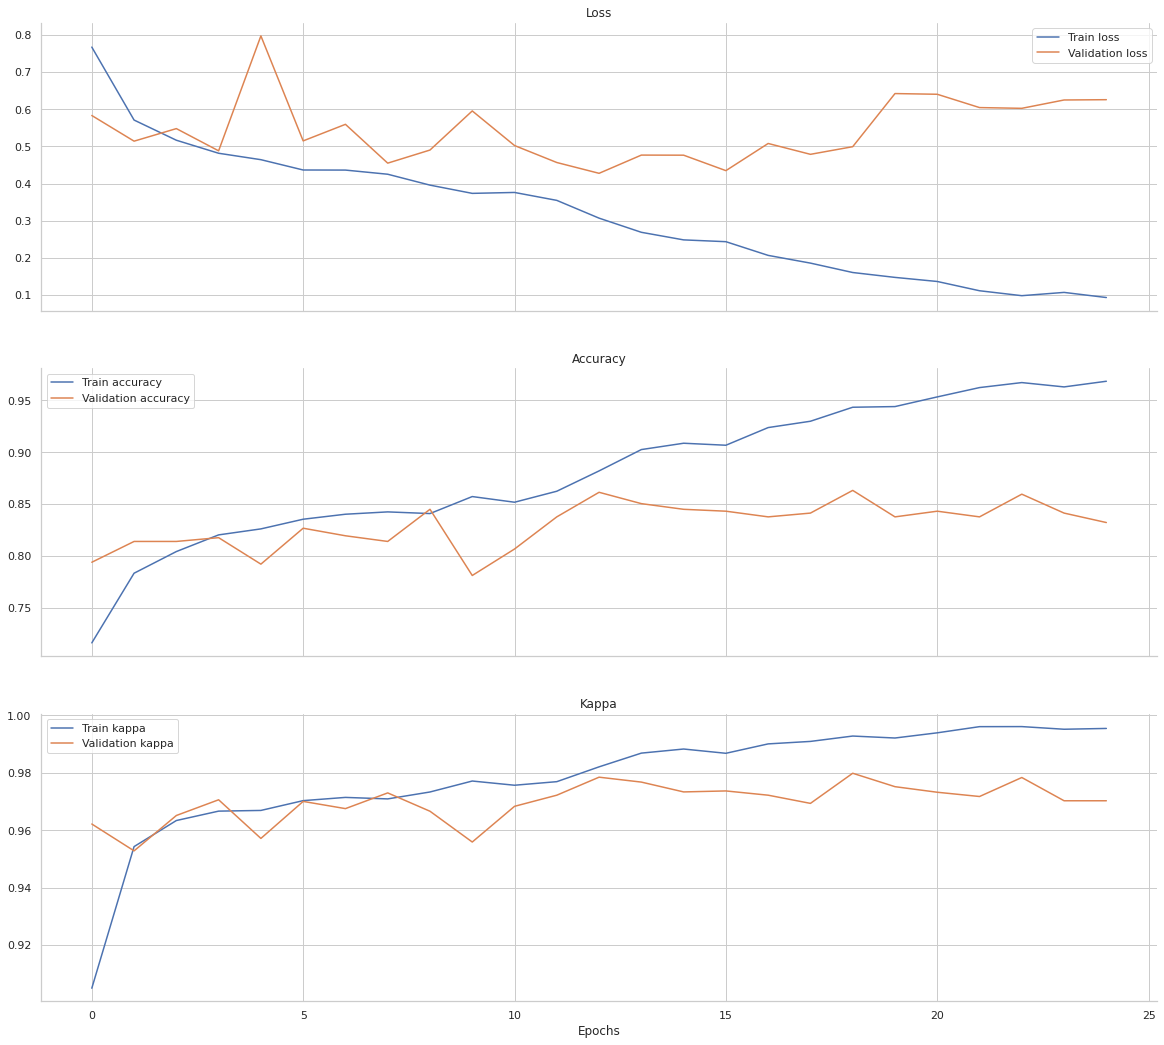

In [18]:
sns.set_style("whitegrid")
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex='col', figsize=(20, 18))

ax1.plot(history_finetunning['loss'], label='Train loss')
ax1.plot(history_finetunning['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history_finetunning['accuracy'], label='Train accuracy')
ax2.plot(history_finetunning['val_accuracy'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('Accuracy')

ax3.plot(history_finetunning['kappa'], label='Train kappa')
ax3.plot(history_finetunning['val_kappa'], label='Validation kappa')
ax3.legend(loc='best')
ax3.set_title('Kappa')

plt.xlabel('Epochs')
sns.despine()
plt.show()

In [19]:
# Create empty arays to keep the predictions and labels
lastFullTrainPred = np.empty((0, N_CLASSES))
lastFullTrainLabels = np.empty((0, N_CLASSES))
lastFullValPred = np.empty((0, N_CLASSES))
lastFullValLabels = np.empty((0, N_CLASSES))

# Add train predictions and labels
for i in range(STEP_SIZE_TRAIN+1):
    im, lbl = next(train_generator)
    scores = model.predict(im, batch_size=train_generator.batch_size)
    lastFullTrainPred = np.append(lastFullTrainPred, scores, axis=0)
    lastFullTrainLabels = np.append(lastFullTrainLabels, lbl, axis=0)

# Add validation predictions and labels
for i in range(STEP_SIZE_VALID+1):
    im, lbl = next(val_generator)
    scores = model.predict(im, batch_size=val_generator.batch_size)
    lastFullValPred = np.append(lastFullValPred, scores, axis=0)
    lastFullValLabels = np.append(lastFullValLabels, lbl, axis=0)

# lastFullComPred = np.concatenate((lastFullTrainPred, lastFullValPred))
# lastFullComLabels = np.concatenate((lastFullTrainLabels, lastFullValLabels))

train_preds = [np.argmax(pred) for pred in lastFullTrainPred]
train_labels = [np.argmax(label) for label in lastFullTrainLabels]
validation_preds = [np.argmax(pred) for pred in lastFullValPred]
validation_labels = [np.argmax(label) for label in lastFullValLabels]
# complete_labels = [np.argmax(label) for label in lastFullComLabels]

In [20]:
del lastFullTrainPred, lastFullTrainLabels, lastFullValPred, lastFullValLabels

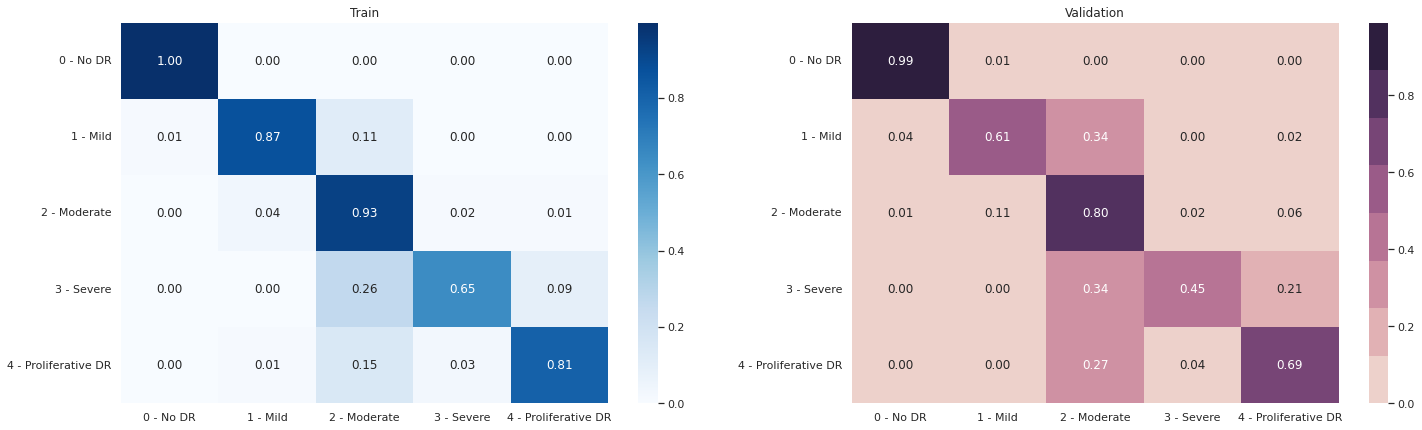

In [21]:
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']

def plot_confusion_matrix(train, validation, labels=labels):
    train_labels, train_preds = train
    validation_labels, validation_preds = validation
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', figsize=(24, 7))
    train_cnf_matrix = confusion_matrix(train_labels, train_preds)
    validation_cnf_matrix = confusion_matrix(validation_labels, validation_preds)

    train_cnf_matrix_norm = train_cnf_matrix.astype('float') / train_cnf_matrix.sum(axis=1)[:, np.newaxis]
    validation_cnf_matrix_norm = validation_cnf_matrix.astype('float') / validation_cnf_matrix.sum(axis=1)[:, np.newaxis]

    train_df_cm = pd.DataFrame(train_cnf_matrix_norm, index=labels, columns=labels)
    validation_df_cm = pd.DataFrame(validation_cnf_matrix_norm, index=labels, columns=labels)

    sns.heatmap(train_df_cm, annot=True, fmt='.2f', cmap="Blues",ax=ax1).set_title('Train')
    sns.heatmap(validation_df_cm, annot=True, fmt='.2f', cmap=sns.cubehelix_palette(8),ax=ax2).set_title('Validation')
    plt.show()

plot_confusion_matrix((train_labels, train_preds), (validation_labels, validation_preds))

In [22]:
def evaluate_model(train, validation):
    train_labels, train_preds = train
    validation_labels, validation_preds = validation
    print("Train        Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds, train_labels, weights='quadratic'))
    print("Validation   Cohen Kappa score: %.3f" % cohen_kappa_score(validation_preds, validation_labels, weights='quadratic'))
    print("Complete set Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds+validation_preds, train_labels+validation_labels, weights='quadratic'))
  

print("   Original thresholds")
evaluate_model((train_preds, train_labels), (validation_preds, validation_labels))

   Original thresholds
Train        Cohen Kappa score: 0.962
Validation   Cohen Kappa score: 0.910
Complete set Cohen Kappa score: 0.954


In [23]:
# def apply_tta(model, generator, steps=5):
#     step_size = generator.n//generator.batch_size
#     preds_tta = []
#     for i in range(steps):
#         generator.reset()
#         preds = model.predict_generator(generator, steps=step_size)
#         preds_tta.append(preds)
    
#     return np.mean(preds_tta, axis=0)

In [24]:
# preds = apply_tta(model, test_generator)
# predictions = np.argmax(preds, axis=1)

In [25]:
# For preprocessing test images
test_generator = ImageDataGenerator(preprocessing_function=preprocess_image, 
                                    rescale=1./255).flow_from_dataframe(test_df, 
                                                                          x_col='id_code',
                                                                          directory=TEST_IMG_PATH,
                                                                          target_size=(WIDTH, HEIGHT),
                                                                          batch_size=1,
                                                                          class_mode=None,
                                                                          shuffle=False)

Found 1928 validated image filenames.


In [26]:
test_generator.reset()
STEP_SIZE_TEST = test_generator.n // test_generator.batch_size
preds = model.predict_generator(test_generator, steps=STEP_SIZE_TEST)
predictions = [np.argmax(pred) for pred in preds]

In [27]:
filenames = test_generator.filenames
results = pd.DataFrame({'id_code':filenames, 'diagnosis':predictions})
results['id_code'] = results['id_code'].map(lambda x : str(x)[:-4])
results.to_csv('submission.csv', index=False)
results.head(10)

,id_code,diagnosis
0,0005cfc8afb6,2
1,003f0afdcd15,3
2,006efc72b638,3
3,00836aaacf06,2
4,009245722fa4,2
5,009c019a7309,2
6,010d915e229a,3
7,0111b949947e,1
8,01499815e469,3
9,0167076e7089,0


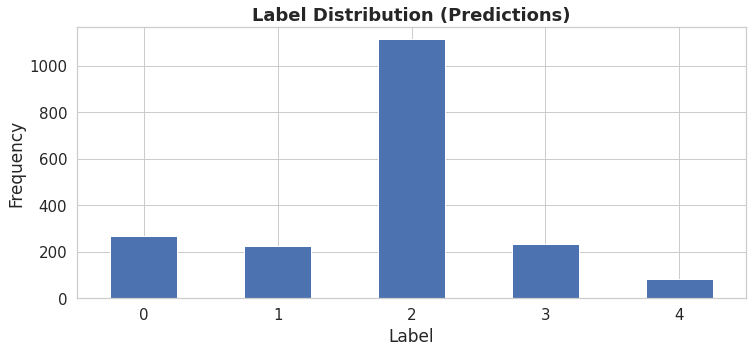

In [28]:
test_df['diagnosis'] = predictions
# Distribution of predictions
test_df['diagnosis'].value_counts().sort_index().plot(kind="bar", 
                                                      figsize=(12,5), 
                                                      rot=0)
plt.title("Label Distribution (Predictions)", 
          weight='bold', 
          fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Label", fontsize=17)
plt.ylabel("Frequency", fontsize=17);

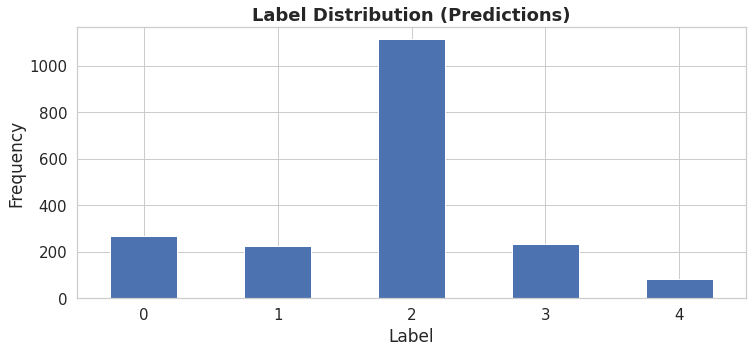

In [29]:
# Distribution of predictions
test_df['diagnosis'].value_counts().sort_index().plot(kind="bar", 
                                                      figsize=(12,5), 
                                                      rot=0)
plt.title("Label Distribution (Predictions)", 
          weight='bold', 
          fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Label", fontsize=17)
plt.ylabel("Frequency", fontsize=17);

In [30]:
# Check kernels run-time. GPU limit for this competition is set to ± 9 hours.
t_finish = time.time()
total_time = round((t_finish-t_start) / 3600, 4)
print('Kernel runtime = {} hours ({} minutes)'.format(total_time, 
                                                      int(total_time*60)))

Kernel runtime = 5.4162 hours (324 minutes)
